<a href="https://colab.research.google.com/github/LaithHaleem/MalyaLectures/blob/master/Univariate_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#---------------------------------#
#-- Uploading data file from PC --#
#---------------------------------#
from google.colab import files
UploadedDataFile = files.upload()

Saving Baghdad Bank.xlsx to Baghdad Bank.xlsx


# **Step #0 Initializing Dependencies**



In [ ]:
#----------------------------------------------------------#
#----------- Initializing dependencies packages -----------#
#----------------------------------------------------------#

import sys
import os
import math
import numpy as np
import pandas as pd
import time
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Formatting dates
from pandas.plotting import register_matplotlib_converters # Adds plotting functions for calender dates
from pandas.core.frame import DataFrame
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
plt.style.use('fivethirtyeight')

#----------------------------------------------------------#
#----------- Initializing dependencies function -----------#
#----------------------------------------------------------#

#>>>> Function to provide uploaded file information

def UploadedFileInfo(UploadedFile):
  #Global variables
  global CompanyName
  #File upoloaded information [Name, Extension]
  FileFullPathName = next(iter(UploadedFile))
  CompanyName, Extension = os.path.splitext(FileFullPathName)[0], os.path.splitext(FileFullPathName)[1]
  #Preparing pandas module for calling function dynamically
  Module = __import__('pandas')
  return CompanyName, FileFullPathName, Extension, Module

#>>>> Function to check data file type and make preprocessing to read file dynamically

def CallSuitablePandas(Module, FileFunction, FileFullPathName):
      func = getattr(Module, FileFunction)
      File = func(FileFullPathName)
      File["Date"] = pd.to_datetime(File["Date"])
      File.set_index("Date",inplace=True)
      CompleteDates = pd.date_range(start=min(File.index), end=max(File.index)).difference(File.index)
      return CompleteDates, File

def FillMissingValue(File, Functype, Method = None):
  Functions = ['fillna', 'interpolate']
  for Function in Functions:
    if(Functype == Function):
      func = getattr(File, Functype)
      return func(method=Method)

#>>>> Function to check data file type and make preprocessing to read file dynamically

def PreparingData():
  #Call function of file uploaded information
  CompanyName, FileFullPathName, Extension, Module = UploadedFileInfo(UploadedDataFile)
  #Files type allowed list
  FilesAllowed = [['.xlsx', 'read_excel'], ['.csv', 'read_csv']]
  #Looping for dynamic detecting and call read file function
  for FileEx, FileFunction in FilesAllowed:
    #Checking the extension to call concerned function 
    if Extension == FileEx:
      #Call function of suitable Pandas function depinding on data file type [Extension]
      CompleteDates, File = CallSuitablePandas(Module, FileFunction, FileFullPathName)
      #Checking the completion of dates to processing
      if not CompleteDates.empty: #--> This case means dates are not compeleted <--#
        dtr =pd.date_range(min(File.index), max(File.index), freq='D')
        DateColumn = pd.Series(index=dtr)
        File = pd.concat([File,DateColumn[~DateColumn.index.isin(File.index)]]).sort_index()
        File = File.drop([0],axis=1).fillna(np.nan)
        File.index.names = ['Date']
        #Pnadas documentaion of Fillna and Interpolate
        #>> Fillna >> https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html
        #>> Interpolate >> https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html
        return FillMissingValue(File, 'interpolate', 'time')
      else: #--> This case means dates are compeleted <--#
        return File
    else:
      return None

#>>>> Function to load data from Yahoo Finance

def yf(Target, Start, End):
  #Installing yahoo finance package silently and Importing it
  %pip install yfinance
  import yfinance as yf
  #Returning the loaded data as Pandas Dataframe
  return yf.download(Target, Start, End)

#>>>> Function to plot visualization
def Plot(figsize=(), plots=[], labels=[], title='', legends=[], legloc='upper right'):
  register_matplotlib_converters()
  plt.figure(figsize=figsize)
  years = mdates.YearLocator()
  fig, ax1 = plt.subplots(figsize=figsize)
  ax1.xaxis.set_major_locator(years)
  for plot in plots:
    plt.plot(plot)
  plt.xlabel(labels[0])
  plt.ylabel(labels[1])
  plt.title(title)
  plt.legend(legends,loc=legloc)
  plt.grid(visible=True)
  plt.show()

# **Step #1 Loading & Pre-processing Data**

In [ ]:
#Loading data
data = PreparingData()

#Feature selection - Only close price
ClosePriceExtracted = data.filter(['Close'])
UnscaledData = ClosePriceExtracted.values

#Transform features by scaling each feature to a range between 0 and 1
MMScaler = MinMaxScaler(feature_range=(0, 1))
ScaledData = MMScaler.fit_transform(UnscaledData)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


<Figure size 864x432 with 0 Axes>

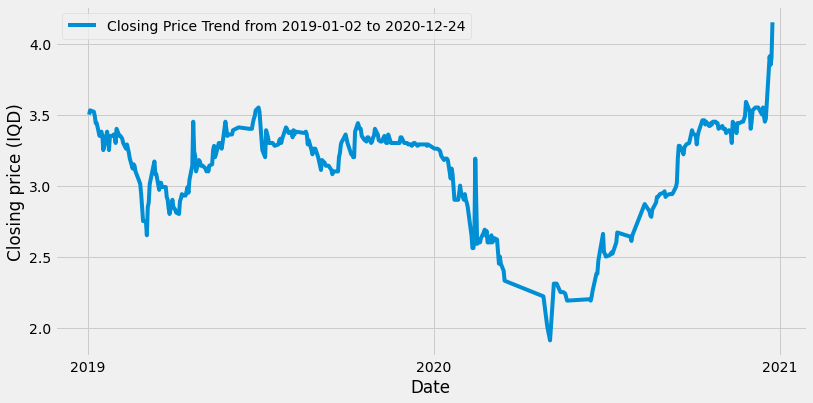

In [ ]:
#Visualizing close price trend
Plot((12, 6), [data['Close']], labels=['Date', 'Closing price (IQD)'], title='', legends=['Closing Price Trend from '+ str(min(data.index)).split(' ')[0] + ' to ' + str(max(data.index)).split(' ')[0]], legloc='upper left')

# **Step #2 Building & Training Model**

In [ ]:
#Build and train the model
def Fit_model(data_sample,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []

    global train_data_length

    #Get the number of rows to train the model on 80% of the data 
    train_data_length = math.ceil(len(data_sample) * 0.8)

    #Loop for training data
    for i in range(timesteps, len(data_sample[0:train_data_length, :])):
        X_train.append(data_sample[i-timesteps:i])
        Y_train.append(data_sample[i])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    #Loop for test data
    for i in range(timesteps, len(data_sample[train_data_length - timesteps:, :])):
        X_test.append(data_sample[i-timesteps:i])
        Y_test.append(data_sample[i])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    #Adding Layers to the model
    model = Sequential()
    model.add(LSTM(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer="sgd", loss = 'mean_squared_error')
  
    #Training the data
    Predictor = model.fit(X_train,Y_train,epochs = epochs, batch_size = batch, validation_data = (X_test, Y_test),
                        verbose = 0)
    #model.reset_states()
    return model, Predictor.history['loss'], Predictor.history['val_loss']

# **Step #3 Predicting & Evaluating Model**

In [ ]:
#Evaluating the model
def Predict_model(model,test,timesteps):
    X_test = []
    Y_test = []

    #Loop for testing data
    for i in range(timesteps, len(test[train_data_length - timesteps:, :])):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #Prediction Time !!!!
    Y_hat = model.predict(X_test)
    Y_hat = MMScaler.inverse_transform(Y_hat)
    return Y_test, Y_hat

def Evaluate_model(y_test, y_hat):
    mse = mean_squared_error(y_test,y_hat)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_test, y_hat)
    return mse, rmse, r2

# **Step #4 Model Implementation**

In [ ]:
#Fitting model
model, loss, val_loss = Fit_model(ScaledData, 60, [40, 35], 1e-3, 64, 1000)

#Predicting model
Y_test, Y_hat = Predict_model(model,ScaledData,60)

#Evaluating model
MSE, RMSE, R2 = Evaluate_model(Y_test, Y_hat)

In [ ]:
Y_train = ClosePriceExtracted[:train_data_length]
Y_test = ClosePriceExtracted[train_data_length:]
Y_test.insert(loc=1, column='Predicted', value=Y_hat)

<Figure size 864x576 with 0 Axes>

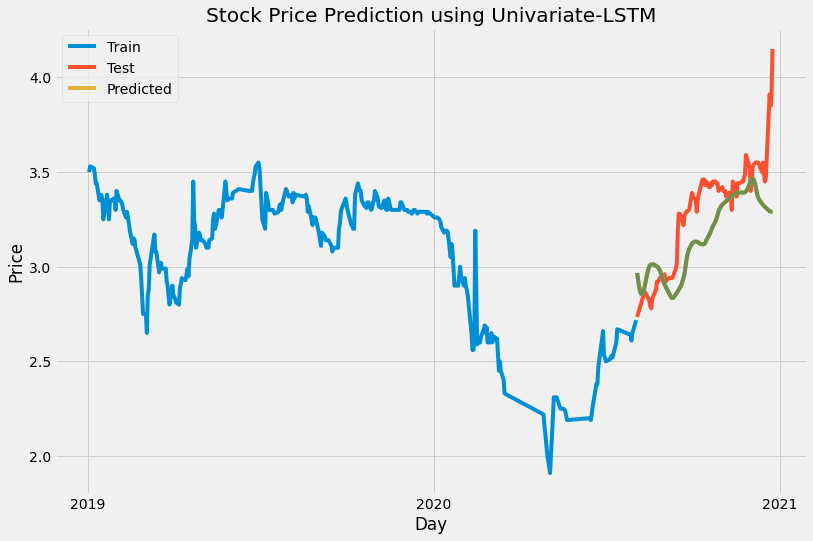

,Close,Predicted
Date,,
2020-08-03,2.734615,2.966586
2020-08-04,2.751538,2.933475
2020-08-05,2.768462,2.898027
2020-08-06,2.785385,2.873268
2020-08-07,2.802308,2.857568
...,...,...
2020-12-20,3.800000,3.297489
2020-12-21,3.910000,3.293990
2020-12-22,3.850000,3.291197


In [ ]:

# Plotting the predictions
#Plotting train and validation loss curve
Fig_size = (12, 8)
Fig_plots = [Y_train, Y_test, Y_test['Predicted']]
Fig_labels = ['Day', 'Price']
Fig_title = 'Stock Price Prediction using Univariate-LSTM'
Fig_legends = ['Train', 'Test', 'Predicted']
Plot(Fig_size, Fig_plots, Fig_labels, Fig_title, Fig_legends, 'upper left')

<Figure size 720x432 with 0 Axes>

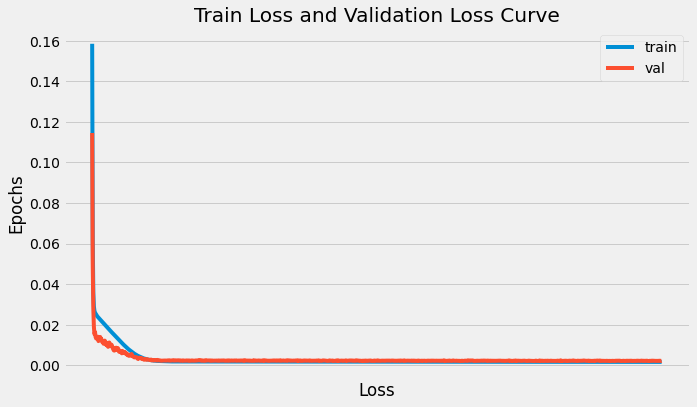

In [ ]:
#Plotting train and validation loss curve
Fig_size = (10, 6)
Fig_plots = [loss, val_loss]
Fig_labels = ['Loss', 'Epochs']
Fig_title = 'Train Loss and Validation Loss Curve'
Fig_legends = ['train', 'val']
Plot(Fig_size, Fig_plots, Fig_labels, Fig_title, Fig_legends)

# **Step #5 Predict Next Days In The Future**

In [ ]:
#Function to predict N step ahead in the future of stock price
def Predict_future(model, step_ahead, step_look_back, traget):
    main_data = PreparingData()

    #Create prediction dates
    last_date = main_data.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=step_ahead+1)
    
    #Prediction N days ahead in the future
    traget_price = main_data.filter([traget]).values
    scaled_price = MMScaler.fit_transform(traget_price)
    step_look_back = step_look_back
    prediction_list = scaled_price[-step_look_back:]
    for _ in range(step_ahead):
        x = prediction_list[-step_look_back:]
        x = x.reshape((1, step_look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[step_look_back-1:]
    prediction_list = np.array(prediction_list)
    prediction_list = np.reshape(prediction_list, (-1, 1))
    prediction_list = MMScaler.inverse_transform(prediction_list)
    #Merging the prediction price and new dates in dataframe with dropping the first row [last row in main data]
    Prediction = pd.DataFrame(prediction_list, columns=[traget], index=prediction_dates).rename_axis('Date').iloc[1: , :]
    return Prediction

   
Dates = Predict_future(model, 1, 60, 'Close')
Dates

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Close
Date,
2020-12-25,3.669154
